In [1]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator, build_sam_vit_b
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm 

In [2]:
import os
import shutil
import glob

# Set the directory for searching and the new directory for saving images
search_dir = './data_from_runs/data_1743688766_645412206/'  # Update with your directory to search
output_dir = 'images_from_runs/'  # Update with the directory where you want to save the images

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Use glob to find all the rgb_image.png files
image_files = glob.glob(os.path.join(search_dir, '**', 'rgb_image.png'), recursive=True)

# Copy each image to the new directory with incrementing filenames
for idx, image_file in enumerate(image_files, start=1):
    new_filename = f'{idx}.png'  # You can change the extension if needed
    new_file_path = os.path.join(output_dir, new_filename)
    shutil.copy(image_file, new_file_path)

print(f"All images have been copied to {output_dir} with incrementing filenames.")

All images have been copied to images_from_runs/ with incrementing filenames.


## Instantiate automatic mask generator with SAM   

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()

mask_generator = SamAutomaticMaskGenerator(
    model=build_sam_vit_b(checkpoint="sam_vit_b_01ec64.pth"),
    # Adjusted parameters based on the suggestions:
    points_per_side= 16,  # Reduced segmentation resolution for fewer parts
    pred_iou_thresh= 0.6,  # Lowered IOU threshold to merge regions
    stability_score_thresh= 0.85,  # Lowered stability threshold to allow less precise segmentation
    box_nms_thresh= 0.6,  # Reduced NMS threshold to allow some overlap between parts
    crop_n_layers= 0,  # No additional cropping layers
    min_mask_region_area= 300,  # Increased mask region area threshold to avoid small parts
)

mask_generator.predictor.model.to(device).eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [32]:
image_files = glob.glob(os.path.join('images_from_runs/', '**', '*.png'), recursive=True)
image_files

['images_from_runs/43.png',
 'images_from_runs/31.png',
 'images_from_runs/47.png',
 'images_from_runs/5.png',
 'images_from_runs/23.png',
 'images_from_runs/19.png',
 'images_from_runs/36.png',
 'images_from_runs/27.png',
 'images_from_runs/13.png',
 'images_from_runs/9.png',
 'images_from_runs/1.png',
 'images_from_runs/29.png',
 'images_from_runs/40.png',
 'images_from_runs/53.png',
 'images_from_runs/16.png',
 'images_from_runs/51.png',
 'images_from_runs/14.png',
 'images_from_runs/2.png',
 'images_from_runs/20.png',
 'images_from_runs/41.png',
 'images_from_runs/32.png',
 'images_from_runs/50.png',
 'images_from_runs/11.png',
 'images_from_runs/28.png',
 'images_from_runs/8.png',
 'images_from_runs/25.png',
 'images_from_runs/52.png',
 'images_from_runs/33.png',
 'images_from_runs/49.png',
 'images_from_runs/10.png',
 'images_from_runs/21.png',
 'images_from_runs/48.png',
 'images_from_runs/42.png',
 'images_from_runs/38.png',
 'images_from_runs/26.png',
 'images_from_runs/24.png

In [33]:

output_dir = './masks'
os.makedirs(output_dir, exist_ok=True)
image_files = glob.glob(os.path.join('images_from_runs/', '**', '*.png'), recursive=True)


# Iterate over each image file
for image_file in tqdm.tqdm(image_files):
    # Read the image
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    torch.cuda.empty_cache()
    with torch.inference_mode():
        masks = mask_generator.generate(image)
    # Get the filename without the extension
    image_filename = os.path.splitext(os.path.basename(image_file))[0]
    # Construct the path for saving the .pkl file
    pkl_filename = os.path.join(output_dir, f'{image_filename}.pkl')
    # Save the entire masks dictionary
    with open(pkl_filename, 'wb') as f:
        pickle.dump(masks, f)

    print(f"Segmentation results for {image_filename} saved as {pkl_filename}")

print("All segmentation results have been saved.")

  2%|▏         | 1/53 [00:01<01:17,  1.50s/it]

Segmentation results for 43 saved as ./masks/43.pkl


  4%|▍         | 2/53 [00:03<01:18,  1.54s/it]

Segmentation results for 31 saved as ./masks/31.pkl


  6%|▌         | 3/53 [00:04<01:16,  1.52s/it]

Segmentation results for 47 saved as ./masks/47.pkl


  8%|▊         | 4/53 [00:06<01:13,  1.51s/it]

Segmentation results for 5 saved as ./masks/5.pkl


  9%|▉         | 5/53 [00:07<01:12,  1.50s/it]

Segmentation results for 23 saved as ./masks/23.pkl


 11%|█▏        | 6/53 [00:09<01:11,  1.52s/it]

Segmentation results for 19 saved as ./masks/19.pkl


 13%|█▎        | 7/53 [00:10<01:09,  1.50s/it]

Segmentation results for 36 saved as ./masks/36.pkl


 15%|█▌        | 8/53 [00:12<01:06,  1.49s/it]

Segmentation results for 27 saved as ./masks/27.pkl


 17%|█▋        | 9/53 [00:13<01:06,  1.51s/it]

Segmentation results for 13 saved as ./masks/13.pkl


 19%|█▉        | 10/53 [00:15<01:06,  1.54s/it]

Segmentation results for 9 saved as ./masks/9.pkl


 21%|██        | 11/53 [00:16<01:04,  1.54s/it]

Segmentation results for 1 saved as ./masks/1.pkl


 23%|██▎       | 12/53 [00:18<01:02,  1.53s/it]

Segmentation results for 29 saved as ./masks/29.pkl


 25%|██▍       | 13/53 [00:19<01:01,  1.54s/it]

Segmentation results for 40 saved as ./masks/40.pkl


 26%|██▋       | 14/53 [00:21<00:59,  1.53s/it]

Segmentation results for 53 saved as ./masks/53.pkl


 28%|██▊       | 15/53 [00:22<00:58,  1.54s/it]

Segmentation results for 16 saved as ./masks/16.pkl


 30%|███       | 16/53 [00:24<00:57,  1.55s/it]

Segmentation results for 51 saved as ./masks/51.pkl


 32%|███▏      | 17/53 [00:26<00:56,  1.56s/it]

Segmentation results for 14 saved as ./masks/14.pkl


 34%|███▍      | 18/53 [00:27<00:53,  1.54s/it]

Segmentation results for 2 saved as ./masks/2.pkl


 36%|███▌      | 19/53 [00:29<00:52,  1.55s/it]

Segmentation results for 20 saved as ./masks/20.pkl


 38%|███▊      | 20/53 [00:30<00:50,  1.54s/it]

Segmentation results for 41 saved as ./masks/41.pkl


 40%|███▉      | 21/53 [00:32<00:48,  1.52s/it]

Segmentation results for 32 saved as ./masks/32.pkl


 42%|████▏     | 22/53 [00:33<00:47,  1.54s/it]

Segmentation results for 50 saved as ./masks/50.pkl


 43%|████▎     | 23/53 [00:35<00:46,  1.56s/it]

Segmentation results for 11 saved as ./masks/11.pkl


 45%|████▌     | 24/53 [00:36<00:44,  1.54s/it]

Segmentation results for 28 saved as ./masks/28.pkl


 47%|████▋     | 25/53 [00:38<00:43,  1.54s/it]

Segmentation results for 8 saved as ./masks/8.pkl


 49%|████▉     | 26/53 [00:39<00:41,  1.54s/it]

Segmentation results for 25 saved as ./masks/25.pkl


 51%|█████     | 27/53 [00:41<00:40,  1.55s/it]

Segmentation results for 52 saved as ./masks/52.pkl


 53%|█████▎    | 28/53 [00:43<00:39,  1.56s/it]

Segmentation results for 33 saved as ./masks/33.pkl


 55%|█████▍    | 29/53 [00:44<00:37,  1.55s/it]

Segmentation results for 49 saved as ./masks/49.pkl


 57%|█████▋    | 30/53 [00:46<00:35,  1.53s/it]

Segmentation results for 10 saved as ./masks/10.pkl


 58%|█████▊    | 31/53 [00:47<00:33,  1.53s/it]

Segmentation results for 21 saved as ./masks/21.pkl


 60%|██████    | 32/53 [00:49<00:31,  1.52s/it]

Segmentation results for 48 saved as ./masks/48.pkl


 62%|██████▏   | 33/53 [00:50<00:30,  1.53s/it]

Segmentation results for 42 saved as ./masks/42.pkl


 64%|██████▍   | 34/53 [00:52<00:28,  1.51s/it]

Segmentation results for 38 saved as ./masks/38.pkl


 66%|██████▌   | 35/53 [00:53<00:27,  1.52s/it]

Segmentation results for 26 saved as ./masks/26.pkl


 68%|██████▊   | 36/53 [00:55<00:26,  1.54s/it]

Segmentation results for 24 saved as ./masks/24.pkl


 70%|██████▉   | 37/53 [00:56<00:24,  1.53s/it]

Segmentation results for 30 saved as ./masks/30.pkl


 72%|███████▏  | 38/53 [00:58<00:22,  1.53s/it]

Segmentation results for 15 saved as ./masks/15.pkl


 74%|███████▎  | 39/53 [00:59<00:21,  1.53s/it]

Segmentation results for 4 saved as ./masks/4.pkl


 75%|███████▌  | 40/53 [01:01<00:20,  1.54s/it]

Segmentation results for 45 saved as ./masks/45.pkl


 77%|███████▋  | 41/53 [01:02<00:18,  1.53s/it]

Segmentation results for 46 saved as ./masks/46.pkl


 79%|███████▉  | 42/53 [01:04<00:16,  1.53s/it]

Segmentation results for 3 saved as ./masks/3.pkl


 81%|████████  | 43/53 [01:05<00:15,  1.53s/it]

Segmentation results for 17 saved as ./masks/17.pkl


 83%|████████▎ | 44/53 [01:07<00:13,  1.53s/it]

Segmentation results for 7 saved as ./masks/7.pkl


 85%|████████▍ | 45/53 [01:08<00:12,  1.54s/it]

Segmentation results for 35 saved as ./masks/35.pkl


 87%|████████▋ | 46/53 [01:10<00:10,  1.52s/it]

Segmentation results for 6 saved as ./masks/6.pkl


 89%|████████▊ | 47/53 [01:12<00:09,  1.54s/it]

Segmentation results for 34 saved as ./masks/34.pkl


 91%|█████████ | 48/53 [01:13<00:07,  1.54s/it]

Segmentation results for 12 saved as ./masks/12.pkl


 92%|█████████▏| 49/53 [01:15<00:06,  1.53s/it]

Segmentation results for 44 saved as ./masks/44.pkl


 94%|█████████▍| 50/53 [01:16<00:04,  1.53s/it]

Segmentation results for 22 saved as ./masks/22.pkl


 96%|█████████▌| 51/53 [01:18<00:03,  1.54s/it]

Segmentation results for 18 saved as ./masks/18.pkl


 98%|█████████▊| 52/53 [01:19<00:01,  1.53s/it]

Segmentation results for 37 saved as ./masks/37.pkl


100%|██████████| 53/53 [01:21<00:00,  1.53s/it]

Segmentation results for 39 saved as ./masks/39.pkl
All segmentation results have been saved.


In [34]:
def convert_box_xywh_to_xyxy(box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[0] + box[2])
    y2 = int(box[1] + box[3])
    return [x1, y1, x2, y2]

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

image_files = glob.glob(os.path.join('images_from_runs/', '**', '*.png'), recursive=True)
mask_files = glob.glob(os.path.join('masks/', '**', '*.pkl'), recursive=True)

# Store embeddings, bboxes, and original image paths for later clustering
embeddings = []
bboxes = []
image_paths = []  # To store the original image path for each cropped patch


for image_file, mask_file in tqdm.tqdm(zip(image_files, mask_files)):
    with open(mask_file, 'rb') as f:
        masks = pickle.load(f)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, mask in enumerate(masks):
        bbox = mask['bbox']
        x1, y1, x2, y2 = convert_box_xywh_to_xyxy(bbox)
        cropped_image = image[y1:y2, x1:x2]
        preprocessed_patch = preprocess(Image.fromarray(cropped_image)).unsqueeze(0).to(device)
        torch.cuda.empty_cache()
        with torch.no_grad():
            embedding = model.encode_image(preprocessed_patch)
        # Store the embedding, bbox, and the original image path
        embeddings.append(embedding.cpu().numpy().flatten())
        bboxes.append([x1, y1, x2, y2])
        image_paths.append(image_file)
# Convert embeddings to a numpy array for clustering
embeddings = np.array(embeddings)

53it [00:14,  3.75it/s]


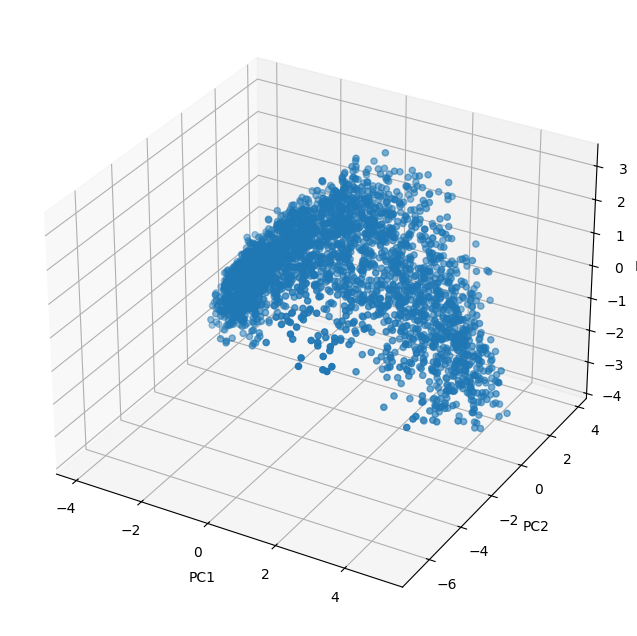

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA with 3 components
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the 3D embeddings
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2])

# Label the axes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()


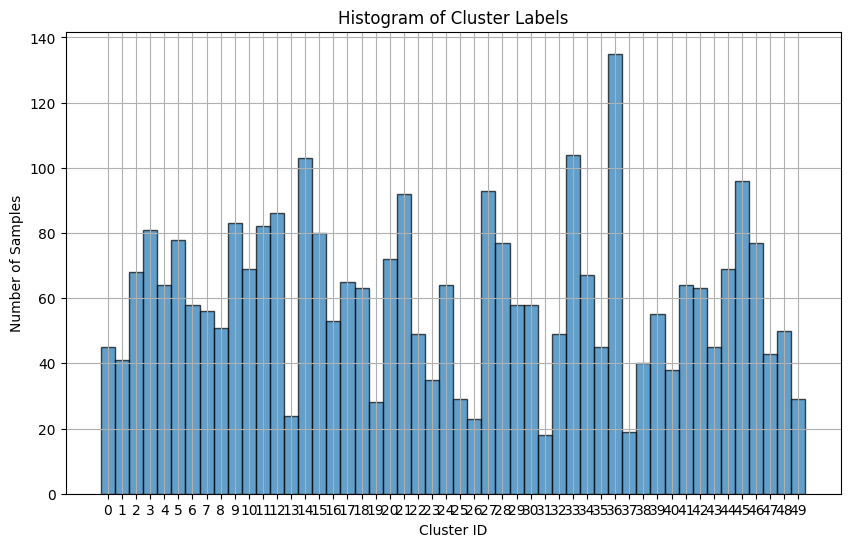

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, KMeans


# Perform DBSCAN clustering on the embeddings
#clustering = DBSCAN(eps=0.01, min_samples=5, metric='cosine').fit(embeddings)
clustering = KMeans(n_clusters=50).fit(embeddings)

# Get clustering labels (each object will have a cluster ID)
labels = clustering.labels_

plt.figure(figsize=(10, 6))
plt.hist(labels, bins=np.arange(labels.min(), labels.max() + 2) - 0.5, edgecolor='black', alpha=0.7)
plt.title('Histogram of Cluster Labels')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.xticks(np.arange(labels.min(), labels.max() + 1))
plt.grid(True)
plt.show()


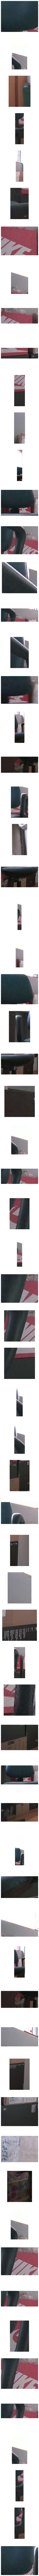

In [38]:
target_cluster = 10
indices = np.where(labels == target_cluster)[0]

# Create subplots with enough space for all images
fig, axes = plt.subplots(len(indices), 1, figsize=(5, len(indices) * 5))

# If only one image, make axes iterable
if len(indices) == 1:
    axes = [axes]

# Iterate over the indices and plot the cropped images
for i, idx in enumerate(indices):
    image_path = image_paths[idx]
    x1, y1, x2, y2 = bboxes[idx]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying
    cropped_image = image[y1:y2, x1:x2]
    
    # Use axes[i] to correctly index the subplots
    axes[i].imshow(cropped_image)
    axes[i].axis('off')  # Turn off the axis labels

plt.show()